In [1]:
import os
import pickle
import numpy as np
import numpy.linalg as la

import PIL.Image
import PIL.ImageSequence

import moviepy
import moviepy.editor
import math
import glob
import csv
from functools import partial
import time
import collections

import sys
sys.path.append("stylegan2")

import run_projector
import projector
import dnnlib
import dnnlib.tflib as tflib

import tensorflow as tf

import keras
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import colorsys
import re
import copy

from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import glob
import gc
import io

Using TensorFlow backend.


In [2]:
##
# 0. Load network snapshots
##

# From https://mega.nz/#!PeIi2ayb!xoRtjTXyXuvgDxSsSMn-cOh-Zux9493zqdxwVMaAzp4 - gwern animefaces stylegan2
input_sg_name = "./models/70knetwork-snapshot-002800.pkl"

tflib.init_tf()

# Load pre-trained network.
with open(input_sg_name, 'rb') as f:
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.    
    _G, _D, Gs = pickle.load(f)
        
# Print network details.
Gs.print_layers()
_D.print_layers()

# For projection
proj = projector.Projector()
proj.set_network(Gs)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.

Gs                          Params    OutputShape       WeightShape     
---                         ---       ---               ---             
latents_in                  -         (?, 512)          -               
labels_in                   -         (?, 0)            -               
lod                         -         ()                -               
dlatent_avg                 -         (512,)            -               
G_mapping/latents_in        -         (?, 512)          -               
G_mapping/labels_in         -         (?, 0)            -               
G_mapping/Normalize         -         (?, 512)          -               
G_mapping/Dense0            262656    (?, 512)          (512, 512)      
G_mapping/Dense1            262656    (?, 512)          (512, 512)      
G_mapping/Dense2            2626

In [3]:
##
# 1. Plain generation
##

# "Ellipse around a point but probably a circle since it's 512 dimensions" laten
def circ_generator(latents_interpolate):
    radius = 40.0

    latents_axis_x = (latents_a - latents_b).flatten() / la.norm(latents_a - latents_b)
    latents_axis_y = (latents_a - latents_c).flatten() / la.norm(latents_a - latents_c)

    latents_x = math.sin(math.pi * 2.0 * latents_interpolate) * radius
    latents_y = math.cos(math.pi * 2.0 * latents_interpolate) * radius

    latents = latents_a + latents_x * latents_axis_x + latents_y * latents_axis_y
    return latents

# Generate images from a list of latents
def generate_from_latents(latent_list, truncation_psi):
    array_list = []
    image_list = []
    for latents in latent_list:
        # Generate image.
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=truncation_psi, randomize_noise=False, output_transform=fmt)
        array_list.append(images[0])
        image_list.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    return array_list, image_list

def mse(x, y):
    return (np.square(x - y)).mean()

# Generate from a latent generator, keeping MSE between frames constant
def generate_from_generator_adaptive(gen_func):
    max_step = 1.0
    current_pos = 0.0
    
    change_min = 10.0
    change_max = 11.0
    
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    
    current_latent = gen_func(current_pos)
    current_image = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
    array_list = []
    
    while(current_pos < 1.0):
        array_list.append(current_image)
        
        lower = current_pos
        upper = current_pos + max_step
        current_pos = (upper + lower) / 2.0
        
        current_latent = gen_func(current_pos)
        current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
        current_mse = mse(array_list[-1], current_image)
        
        while current_mse < change_min or current_mse > change_max:
            if current_mse < change_min:
                lower = current_pos
                current_pos = (upper + lower) / 2.0
            
            if current_mse > change_max:
                upper = current_pos
                current_pos = (upper + lower) / 2.0
                
            
            current_latent = gen_func(current_pos)
            current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
            current_mse = mse(array_list[-1], current_image)
        print(current_pos, current_mse)
        
    return array_list

# We have to do truncation ourselves, since we're not using the combined network
def truncate(dlatents, truncation_psi, maxlayer = 10):
    dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
    layer_idx = np.arange(10)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < maxlayer, truncation_psi * ones, ones)
    return tf.get_default_session().run(tflib.lerp(dlatent_avg, dlatents, coefs))

# Generate image with disentangled latents as input
def generate_images_from_dlatents(dlatents, truncation_psi = 1.0, randomize_noise = True):
    if not truncation_psi is None:
        dlatents_trunc = truncate(dlatents, truncation_psi)
    else:
        dlatents_trunc = dlatents
        
    # Run the network
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 10, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt
    )[0]
    return result_image

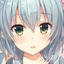

In [4]:
# Just build a single image, randomly
arrays, images = generate_from_latents([np.random.randn(1, Gs.input_shape[1])], 0.5)
images[0]

In [5]:
# Init randomizer, load latents
rnd = np.random # Could seed here if you want to
latents_a = rnd.randn(1, Gs.input_shape[1])
latents_b = rnd.randn(1, Gs.input_shape[1])
latents_c = rnd.randn(1, Gs.input_shape[1])

In [6]:
if os.path.exists("./example_data/latents.npy"):
    latents_a, latents_b, latents_c = np.load("example_data/latents.npy")
np.save("./example_data/latents.npy", np.array([latents_a, latents_b, latents_c]))

In [89]:
# Fixed input example, with dlatents as intermediate
'''
dlatents = Gs.components.mapping.run(latents_a, None)[0]
PIL.Image.fromarray(generate_images_from_dlatents(dlatents, 0.7))
'''

'\ndlatents = Gs.components.mapping.run(latents_a, None)[0]\nPIL.Image.fromarray(generate_images_from_dlatents(dlatents, 0.7))\n'

In [92]:
# Circular interpolation example. uncomment to make a cool movie.

# array_list = generate_from_generator_adaptive(circ_generator)
# clip = moviepy.editor.ImageSequenceClip(array_list, fps=60)
# clip.ipython_display()
# clip.write_videofile("out.mp4")


0.009765625 10.886474609375
0.01806640625 10.215413411458334
0.025390625 10.021565755208334
0.033203125 10.724283854166666
0.041015625 10.507161458333334
0.04931640625 10.445068359375
0.0576171875 10.461344401041666
0.06640625 10.695638020833334
0.0751953125 10.702718098958334
0.08447265625 10.494547526041666
0.09326171875 10.114095052083334
0.100341796875 10.561360677083334
0.107666015625 10.9951171875
0.114990234375 10.192138671875
0.122314453125 10.198974609375
0.129638671875 10.678955078125
0.136474609375 10.448486328125
0.142578125 10.564127604166666
0.1484375 10.226643880208334
0.1552734375 10.345458984375
0.16259765625 10.364013671875
0.16943359375 10.105305989583334
0.17626953125 10.54541015625
0.18359375 10.170572916666666
0.19140625 10.286376953125
0.19970703125 10.346435546875
0.20849609375 10.153727213541666
0.21875 10.804606119791666
0.228515625 10.3154296875
0.2373046875 10.976481119791666
0.24462890625 10.279541015625
0.251220703125 10.352620442708334
0.25830078125 10.53

Moviepy - Done !
Moviepy - video ready __temp__.mp4
Moviepy - Building video out.mp4.
Moviepy - Writing video out.mp4



Moviepy - Done !
Moviepy - video ready out.mp4


In [7]:
##
# 3. Projection - encoding images into latent space
##

# Projects an image into dlatent space and returns the dlatents
def encode_image(image, steps=1000, verbose=True):
    image_processed = np.array(copy.deepcopy(image).convert('RGB').resize((512, 512), resample = PIL.Image.LANCZOS)) / 255.0
    image_processed = (image_processed.transpose(2, 0, 1) - 0.5) * 2.0
    image_processed = np.array([image_processed])
    proj.num_steps = steps
    proj.start(image_processed)
    while proj.get_cur_step() < steps:
        if verbose:
            print('\rProjection: Step %d / %d ... ' % (proj.get_cur_step(), steps), end='', flush=True)
        proj.step()
    print('\r', end='', flush=True)
    return proj.get_dlatents()

In [ ]:
# Note that projection has a random component - if you're not happy with the result, probably retry a few times
# For best results, probably have a single person facing the camera with a neutral white background
# Replace "input.png" with your own image if you want to use something other than toshiko koshijima, however unlikely this may be
"""
image = PIL.Image.open("input.png") # Default is toshiko koshijima
proj_dlatents = encode_image(image, 200)

image_projected = generate_images_from_dlatents(proj_dlatents, 0.4)
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.subplot(1, 2, 2)
plt.imshow(image_projected)
"""

In [8]:
##
# 3. Modification - prepararing data for training dlatent dirs
##

# Generate samples to pass to the tagger model
def generate_one_for_latentdirs(truncation_psi = 0.7, randomize_noise = True):
    latents = rnd.randn(1, Gs.input_shape[1])
    dlatents = Gs.components.mapping.run(latents, None)[0]
    dlatents_trunc = truncate(dlatents, truncation_psi)
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 10, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt
    )[0]
    return latents, dlatents, result_image

# This gets slower as we go so lets go in steps of 100 to see if that alleviates the issue
# of course, this doesn't work, on account of my GPU memory being too small. minibatch 10, maybe?
# I want a ti 2080 11gb quite badly
def generate_many_for_latentdirs(truncation_psi = 0.7, randomize_noise = True):
    latents = rnd.randn(100, Gs.input_shape[1])
    dlatents = Gs.components.mapping.run(latents, None)
    dlatents_trunc = truncate(dlatents, truncation_psi)
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 10, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 10,
        output_transform=fmt
    )
    return latents, dlatents, result_image

In [112]:
# Unfortunately, stylegan 2 only runs on tf 1.14, while deepdanbooru current uses tf 2 - so we just save images here
# and tag them later (see DeepDanbooru-Playground notebook)

# latent_list = []
# dlatent_list = []
# image_list = []
# image_count = 100000 # Increment to resume
# count = 0
# for i in range(1000):
#     tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))
#     tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))
#     tags_todo = sorted(list(tags_required.difference(tags_exist)))
    
# #     if len(tags_todo) > 0:
# #         print("Waiting for tagger, resuming in 120s, queue depth:", len(tags_todo))
# #         time.sleep(120)
# #     else:
#         # Vary psi a little
#     psi = 0.7
#     if len(image_list) < 200:
#         psi = 0.5
#     if len(image_list) < 500:
#         psi = 0.6

#     latents, dlatents, image = generate_many_for_latentdirs(truncation_psi = psi)
#     latent_list.extend(latents)
#     dlatent_list.extend(dlatents)
#     image_list.extend(image)
#     #if len(image_list) % 100 == 0:
    
#     count += 100
#     print(count)

#     if count % 10000 == 0:
#         with open("dlatents_for_tagging_{}.pkl".format(count), 'wb') as f:
#             pickle.dump((latent_list, dlatent_list, image_list), f)
#         print("Wrote", "dlatents_for_tagging_{}.pkl".format(count))
#         latent_list = []
#         dlatent_list = []
#         image_list = []
   

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Wrote dlatents_for_tagging_10000.pkl
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
179

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[10,3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/Square (defined at <string>:104) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[G_synthesis_5/_Run/saturate_cast/_3105]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[10,3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/Square (defined at <string>:104) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/Square:
 G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/mul_3 (defined at <string>:100)

Input Source operations connected to node G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/Square:
 G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/mul_3 (defined at <string>:100)

Original stack trace for 'G_synthesis_5/_Run/G_synthesis/8x8/Conv0_up/Square':
  File "D:\anaconda\envs\py3610\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\anaconda\envs\py3610\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\anaconda\envs\py3610\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "D:\anaconda\envs\py3610\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "D:\anaconda\envs\py3610\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "D:\anaconda\envs\py3610\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "D:\anaconda\envs\py3610\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "D:\anaconda\envs\py3610\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "D:\anaconda\envs\py3610\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "D:\anaconda\envs\py3610\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "D:\anaconda\envs\py3610\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\anaconda\envs\py3610\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\anaconda\envs\py3610\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "D:\anaconda\envs\py3610\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "D:\anaconda\envs\py3610\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "D:\anaconda\envs\py3610\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\anaconda\envs\py3610\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "D:\anaconda\envs\py3610\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-106-f56a857203e1>", line 24, in <module>
    latents, dlatents, image = generate_many_for_latentdirs(truncation_psi = psi)
  File "<ipython-input-105-7310663b6168>", line 31, in generate_many_for_latentdirs
    output_transform=fmt
  File "stylegan2\dnnlib\tflib\network.py", line 417, in run
    out_gpu = net_gpu.get_output_for(*in_gpu, return_as_list=True, **dynamic_kwargs)
  File "stylegan2\dnnlib\tflib\network.py", line 221, in get_output_for
    out_expr = self._build_func(*final_inputs, **build_kwargs)
  File "<string>", line 498, in G_synthesis_stylegan2
  File "<string>", line 468, in block
  File "<string>", line 455, in layer
  File "<string>", line 104, in modulated_conv2d_layer
  File "D:\anaconda\envs\py3610\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 11416, in square
    "Square", x=x, name=name)
  File "D:\anaconda\envs\py3610\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "D:\anaconda\envs\py3610\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "D:\anaconda\envs\py3610\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "D:\anaconda\envs\py3610\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [110]:
# tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))
# print(tags_required)

{'100000.pkl', '105000.pkl'}


In [9]:
# Load the tags from the DeepDanbooru notebook, and probably re-load the latents, as we just restarted the kernel

# image_tags = []
# latent_list = []
# dlatent_list = []

# tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))
# for i in tags_exist:
#     with open("image_tags_" + i, 'rb') as f:
#         image_tags_tmp = pickle.load(f)
        
#     with open("dlatents_for_tagging_" + i, 'rb') as f:    
#         latent_list_tmp, dlatent_list_tmp, _ = pickle.load(f)
        
#     image_tags.extend(image_tags_tmp)
#     latent_list.extend(latent_list_tmp)
#     dlatent_list.extend(list(np.array(dlatent_list_tmp).reshape(-1, 10, 512)[:, 0, :]))
    
# gc.collect()
# dlatents_for_regression = np.array(dlatent_list).reshape(-1, 512)    


In [24]:
# image_tags = []
# latent_list = []
# dlatent_list = []
# with open("image_tags_2000.pkl", 'rb') as f:
#         image_tags_tmp = pickle.load(f)
# with open("dlatents_for_tagging_2000.pkl", 'rb') as f:    
#         latent_list_tmp, dlatent_list_tmp, _ = pickle.load(f)
# image_tags.extend(image_tags_tmp)
# latent_list.extend(latent_list_tmp)
# dlatent_list.extend(list(np.array(dlatent_list_tmp).reshape(-1, 10, 512)[:, 0, :]))

# gc.collect()
# dlatents_for_regression = np.array(dlatent_list).reshape(-1, 512)    

In [10]:
# print(image_tags[2])

OrderedDict([('mosaic_censoring', 1.0), ('censored', 1.0), ('1girl', 0.9994281), ('identity_censor', 0.9981413), ('pixel_art', 0.9941116), ('rating:explicit', 0.9914609), ('bangs', 0.9223003), ('1boy', 0.7830459), ('shiny', 0.7592647), ('eyebrows_visible_through_hair', 0.6823235), ('looking_at_viewer', 0.6800001), ('penis', 0.66075736), ('hair_between_eyes', 0.6490948), ('leather', 0.64124), ('solo', 0.5860614), ('white_border', 0.5659375), ('sweat', 0.553663), ('raised_eyebrows', 0.52261585), ('large_penis', 0.46381462), ('brown_eyes', 0.4505975), ('tongue', 0.44889238), ('blush', 0.4260179), ('tongue_out', 0.42231515), ('middle_finger', 0.41037366), ('sidelocks', 0.40682802), ('flaccid', 0.39361644), ('white_background', 0.37667155), ('hetero', 0.37241524), ('virtual_youtuber', 0.3682304), ('grey_skin', 0.36679912), ('indoors', 0.36470264), ('transparent_background', 0.34759423), ('high_ponytail', 0.3464049), ('open_mouth', 0.33284512), ('shiny_skin', 0.29824212), ('nose_blush', 0.27

In [11]:
# Turn into features for learning directions

# all_tags = collections.defaultdict(int)
# for tags in image_tags:
#     for tag in tags:
#         all_tags[tag] += 1
# tags_by_popularity = sorted(all_tags.items(), key = lambda x: x[1], reverse = True)
# eye_tags = list(filter(lambda x: x[0].endswith("_eyes"), tags_by_popularity))
# hair_tags = list(filter(lambda x: x[0].endswith("_hair"), tags_by_popularity))

# tag_binary_feats = {}
# tag_continuous_feats = {}
# for tag, _ in tags_by_popularity:
#     this_tag_feats = []
#     this_tag_feats_cont = []
#     for tag_list_for_dl in image_tags:
#         this_dl_tag_value = 0.0
#         this_dl_tag_value_cont = 0.0
#         if tag in tag_list_for_dl:
#             this_dl_tag_value = 1.0
#             this_dl_tag_value_cont = tag_list_for_dl[tag]
#         this_tag_feats.append(this_dl_tag_value)
#         this_tag_feats_cont.append(this_dl_tag_value_cont)
#     tag_binary_feats[tag] = np.array(this_tag_feats)
#     tag_continuous_feats[tag] = np.array(this_tag_feats_cont)


In [54]:
# print(tags_by_popularity)
# print(eye_tags)
# print(hair_tags)

[('mosaic_censoring', 80000), ('censored', 80000), ('identity_censor', 80000), ('rating:explicit', 80000), ('1girl', 80000), ('penis', 79996), ('1boy', 79994), ('shiny', 79943), ('large_breasts', 79940), ('from_above', 79666), ('tongue', 79660), ('sweat', 79659), ('tongue_out', 79642), ('indoors', 79570), ('open_mouth', 79563), ('hetero', 79487), ('flaccid', 79286), ('bangs', 79106), ('erection', 78671), ('brown_eyes', 78295), ('looking_at_viewer', 77502), ('pixel_art', 77246), ('shiny_skin', 77232), ('leather', 76687), ('eyebrows_visible_through_hair', 74076), ('raised_eyebrows', 73927), ('large_penis', 73561), ('licking_penis', 73253), ('hair_between_eyes', 72378), ('sidelocks', 68891), ('uvula', 68122), ('nude', 67640), ('high_ponytail', 67586), ('white_bow', 66465), ('copyright', 66435), ('patreon_logo', 66098), ('testicles', 65735), ('standing', 65312), ('clothed_sex', 64615), ('blush', 64410), ('breasts', 63795), ('frills', 62380), ('after_fellatio', 61111), ('collarbone', 60646)

In [96]:
# # Learn directions for tags (binarized) using logistic regression classification
# # Thought: Why not apply L1 regu here to enforce sparsity?
# # -> I feel this has neither improved nor worsened the situation (default settings)
# # -> With really extreme sparsity constraint, it does, not work very well. Is my assumption that dlatents should be
# #    sparse wrt tags wrong? Probably is.
# # -> For now, plain logistic regression gives best results
# def find_direction_binary(dlatents, targets):
#     #clf = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, C=0.001).fit(dlatents, targets)
#     clf = LogisticRegression().fit(dlatents, targets)
#     return np.repeat(clf.coef_.reshape(1,512), 10, axis = 0)

# # Alternate version: Learn directions by fitting a linear regression onto the probabilities
# # Questions:
# # * Problem should be sparse - Lasso / Elasticnet?
# #    -> ElasticNet does empathically Not work, regularizes everything to 0 (lol)
# #    -> Same for Lasso :(
# #    -> Lower alpha term? omit intercept?
# #    -> seems like it would be really useful, though (not to mention faster), since we _expect_ sparsity here.
# #    -> retry later with more data?
# #    -> oh lol I'm fucking dumb why was I doing this with the inputs for every level. they're identical. there's just 512.
# # * Not the most well-posed problem just generally -> really do need more samples. sighs.
# # * Conclusion currently: Doesn't work all that well even though in theory it totally should
# # * Or may it it would if you did not Fuck It Up you turbo moron. Retrying with not broken labels now.
# #    -> suddenly it works great
# def find_direction_continuous(dlatents, targets):
#     clf = Lasso(alpha=0.01, fit_intercept=False).fit(dlatents, targets)
#     if np.abs(np.sum(clf.coef_)) == 0.0:
#         clf = Lasso(alpha=0.001, fit_intercept=False).fit(dlatents, targets)
#     return  np.repeat(clf.coef_.reshape(1,512), 10, axis = 0)

# # Alternate idea: Fit gauss mixture, gradient descend in that
# # -> Ooooor, possibly: gauss mixture mapping kind of simultaneous likelihood maximization type stuff?
# # -> that sounds super fun lets try it
# # -> But first, the Super Baby Version: Just move towards weighted mean
# # -> Works okish, but only okayish
# def find_distrib_continuous(dlatents, targets):
#     tag_mean = np.sum(dlatents * targets.reshape(-1, 1), axis = 0) / np.sum(targets)
#     return  np.repeat(tag_mean.reshape(1,512), 10, axis = 0)


# popular_tags = list(filter(lambda x: x[1] > 1 and x[1] < 500, tags_by_popularity))
# good_tags = popular_tags


# # Would still like to try to use the tagger network to do direct gradient descent of dlatents with tag loss

In [97]:
# print(good_tags)
# wanted_tags = ['eyebrows_visible_through_hair','raised_eyebrows','high_ponytail','blush','dark_skin','body_blush','nose_blush',
#                'furrowed_eyebrows','black_skin','smile','grey_skin','from_below','closed_mouth','eyelashes','pale_skin',':d',
#               'hair_ribbon','white_ribbon','white_skin','tears','greyscale']
# good_tags = list(filter(lambda x: x[0].endswith("_hair") or x[0].endswith("_eyes") or x[0] in wanted_tags, good_tags))
# print(good_tags)


[('sweater_vest', 484), ('tanline', 484), ('blue_pants', 461), ('crossdressing', 457), ('jester_cap', 457), (':3', 416), ('puffy_sleeves', 409), ('skyscraper', 391), ('gas_mask', 390), ('cleavage', 388), ('blue_hair', 374), ('shaved_ice', 367), ('breastless_clothes', 358), ('triangle_mouth', 355), ('door', 354), ('green_shirt', 346), ('thigh_gap', 344), ('cumdrip', 333), ('dog_tags', 333), ('nose', 325), ('company_name', 321), ('side-by-side', 320), ('frilled_bow', 313), ('ass', 313), ('nishizumi_maho', 304), ('red_pupils', 298), ('stray_pubic_hair', 292), ('bonnet', 285), ('short_sleeves', 274), ('pants', 272), ('patreon_username', 271), ('frog', 267), ('barcode', 263), ('yin_yang', 263), ('upper_body', 259), ('multicolored_hair', 254), ('thigh_sex', 254), ('green_pants', 252), ('red_neckwear', 245), ('after_sex', 245), ('armor', 244), ('grabbing_from_behind', 241), ('headphones_around_neck', 240), ('puffy_nipples', 228), ("jeanne_d'arc_(alter_swimsuit_berserker)", 227), ('outside_bor

In [98]:
# # Try to make the directions a bit more orthogonal
# # In retrospect, this obviously works against stylegans own attempts to do the same thing, so e h
# # -> it did not work very well

# dlatent_pca = PCA()
# dlatent_pca.fit(dlatents_for_regression)
# dlatents_for_regression_transformed = dlatent_pca.transform(dlatents_for_regression)


In [99]:
# # Calculate actual directions for modifications

# tag_directions = {}
# for i, (tag, _) in enumerate(good_tags):
#     print("Estimating direction for", tag, "(", i, ")")
#     # Variant A: Binary labels, logistic regression
#     tag_directions[tag] = find_direction_binary(dlatents_for_regression, tag_binary_feats[tag])
    
#     # Variant B: Continuous labels (confidence from deepdanbooru), Lasso regression
# #     tag_directions[tag] = find_direction_continuous(dlatents_for_regression, tag_continuous_feats[tag])
    
#     # Variant C: means and move to mean
#     #tag_directions[tag] = find_distrib_continuous(dlatents_for_regression, tag_continuous_feats[tag])
# with open("tagged_dlatents/tag_dirs_cont.pkl", 'wb') as f:
#     pickle.dump(tag_directions, f)
 

Estimating direction for blue_hair ( 0 )
Estimating direction for stray_pubic_hair ( 1 )
Estimating direction for multicolored_hair ( 2 )
Estimating direction for black_hair ( 3 )
Estimating direction for red_eyes ( 4 )
Estimating direction for male_pubic_hair ( 5 )
Estimating direction for greyscale ( 6 )
Estimating direction for blonde_hair ( 7 )
Estimating direction for lavender_hair ( 8 )
Estimating direction for silver_hair ( 9 )
Estimating direction for very_long_hair ( 10 )
Estimating direction for orange_eyes ( 11 )
Estimating direction for crazy_eyes ( 12 )
Estimating direction for straight_hair ( 13 )
Estimating direction for green_hair ( 14 )
Estimating direction for aqua_eyes ( 15 )
Estimating direction for short_hair ( 16 )
Estimating direction for no_eyes ( 17 )


In [100]:
# print(good_tags)

[('blue_hair', 374), ('stray_pubic_hair', 292), ('multicolored_hair', 254), ('black_hair', 178), ('red_eyes', 167), ('male_pubic_hair', 150), ('greyscale', 125), ('blonde_hair', 85), ('lavender_hair', 38), ('silver_hair', 24), ('very_long_hair', 11), ('orange_eyes', 10), ('crazy_eyes', 4), ('straight_hair', 4), ('green_hair', 3), ('aqua_eyes', 3), ('short_hair', 3), ('no_eyes', 2)]


In [101]:
##
# 4. Modification - basic
##

with open("tagged_dlatents/tag_dirs_cont.pkl", 'rb') as f:
    tag_directions = pickle.load(f)

<StemContainer object of 3 artists>

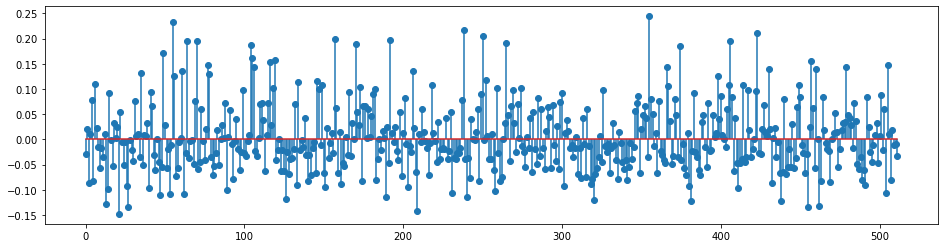

In [103]:
# Lets have a look at the weights.
# Sparse weights <=> most stems 
plt.figure(figsize=(16, 4))
plt.stem(tag_directions["aqua_eyes"][0,:])

In [28]:
# One possible idea: use only the top n (absolute value) weights to make the result sparser yet, top 1 in the extreme
# case (i.e. use ONLY one dimension)
# -> Does help disentangle some things (hairstyle and colour) but makes other things (hair colour and eye colour) worse
# -> Not really an improvement

# top_n = 10
# for tag in tag_directions:
#     top_list = np.argsort(np.abs(tag_directions[tag][0,:]))
#     for i in range(10):
#         tag_directions[tag][i,top_list[:-top_n]] = 0.0
 

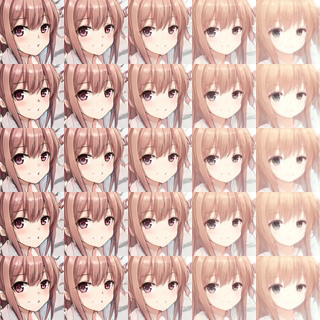

In [104]:

# # Do some modification and display on a grid (move-to-mean ver.)
# dlatents_gen = Gs.components.mapping.run(latents_a, None)[0]

# im = PIL.Image.new('RGB', (64 * 5, 64 * 5))
# for i in range(0, 5):
#     for j in range(0, 5):
#         factor_hair = (i / 5.0) 
#         factor_mouth = (j / 5.0)
    
#         dlatents_mod = copy.deepcopy(dlatents_gen)
# #         dlatents_mod = dlatent_pca.transform(dlatents_mod.reshape(1, 10*512)).reshape(10, 512)
#         dlatents_mod = (1.0 - factor_hair) * dlatents_mod + tag_directions["aqua_eyes"] * factor_hair
# #         dlatents_mod = (1.0 - factor_mouth) * dlatents_mod + tag_directions["closed_mouth"] * factor_mouth
# #         dlatents_mod = dlatent_pca.inverse_transform(dlatents_mod.reshape(1, 10*512)).reshape(10, 512)
        
#         dlatents_mod_image = generate_images_from_dlatents(dlatents_mod, 0.7)
#         im.paste(PIL.Image.fromarray(dlatents_mod_image, 'RGB').resize((64, 64), resample = PIL.Image.LANCZOS), (64 * i, 64 * j))
# im 


In [105]:
print(tag_directions.keys())

dict_keys(['blue_hair', 'stray_pubic_hair', 'multicolored_hair', 'black_hair', 'red_eyes', 'male_pubic_hair', 'greyscale', 'blonde_hair', 'lavender_hair', 'silver_hair', 'very_long_hair', 'orange_eyes', 'crazy_eyes', 'straight_hair', 'green_hair', 'aqua_eyes', 'short_hair', 'no_eyes'])


In [106]:
# Remove some tags that are not all that helpful
tags_use = list(tag_directions.keys())

# tags_use = ['smile', 
#             'closed_mouth','half-closed_eyes', 'pink_eyes', 'pink_hair', 
#             'hair_over_eyes',':d','hair_ribbon',
#             'grey_hair',]

# tags_use.remove("penis")
# tags_use.remove("1girl")
# tags_use.remove("1boy")
# tags_use.remove("large_breasts")
# tags_use.remove("mosaic_censoring")
# tags_use.remove("censored")
# tags_use.remove("rating:explicit")
# tags_use.remove("identity_censor")
# tags_use.remove("2boys")

# tags_use = ['open_mouth', 'from_above', 'brown_eyes', 'shiny_skin', 'hair_between_eyes', 'high_ponytail', 'blush', 
#             'dark_skin', 'teeth', 'shiny_clothes', 'black_skin', 'hands_up', 'smile', 'tied_hair', 'closed_mouth', 
#             'wavy_hair', 'ribbon', 'pink_hair', 'long_hair']
# tags_use = tags_use[:24]
with open("tagged_dlatents/tags_use.pkl", 'wb') as f:
    pickle.dump(tags_use, f)

In [91]:

print(tags_use)

['brown_eyes', 'eyebrows_visible_through_hair', 'raised_eyebrows', 'hair_between_eyes', 'high_ponytail', 'blush', 'dark_skin', 'body_blush', 'shiny_hair', 'nose_blush', 'brown_hair', 'furrowed_eyebrows', 'black_skin', 'eyes_visible_through_hair', 'smile', 'grey_skin', 'tied_hair', 'from_below', 'closed_mouth', 'wavy_hair', 'rolling_eyes', 'half-closed_eyes', 'pink_eyes', 'pink_hair', 'long_hair', 'eyelashes', 'pubic_hair', 'pale_skin', 'hair_over_eyes', 'medium_hair', ':d', 'cum_on_hair', 'hair_ribbon', 'white_ribbon', 'grey_hair', 'purple_hair', 'two-tone_hair', 'reflective_eyes', 'yellow_eyes', 'white_skin', 'tears', 'blue_hair', 'stray_pubic_hair', 'multicolored_hair', 'black_hair', 'red_eyes', 'male_pubic_hair', 'greyscale', 'blonde_hair', 'lavender_hair', 'silver_hair', 'very_long_hair', 'orange_eyes', 'crazy_eyes', 'straight_hair', 'green_hair', 'aqua_eyes', 'short_hair', 'no_eyes']


In [107]:
##
# 4. Modification - interactive
##
hair_eyes_only = False
    
tag_len = {}
for tag in tag_directions:
    tag_len[tag] = np.linalg.norm(tag_directions[tag].flatten())

mod_latents = copy.deepcopy(latents_a)
dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0]  
def modify_and_sample(psi_pre, psi_post, truncate_pre, truncate_post, **kwargs):
    if truncate_pre == True:
        dlatents_mod = truncate(copy.deepcopy(dlatents_gen), psi_pre)
    else:
        dlatents_mod = copy.deepcopy(dlatents_gen)
        
    for tag in kwargs:
        dlatents_mod += tag_directions[tag] * kwargs[tag]  / tag_len[tag] * 25.0
    value_widgets["psi_pre"].value = str(round(psi_pre, 2))
    value_widgets["psi_post"].value = str(round(psi_post, 2))
    
    for tag in kwargs:
        tag_value = round((np.dot(dlatents_mod.flatten(), tag_directions[tag].flatten()) / tag_len[tag]), 2)
        value_widgets[tag].value = str(kwargs[tag]) + " | " + str(tag_value)
    
    display_psi = None
    if truncate_post == True:
        display_psi = psi_post
    display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod, truncation_psi = display_psi), 'RGB'))

psi_slider = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.75, continuous_update = False, readout = False)
psi_slider_post = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.65, continuous_update = False, readout = False)
if hair_eyes_only:
    modify_tags = [tag for tag in tag_directions if "_hair" in tag or "_eyes" in tag or "_mouth" in tag]
else:
    with open("tagged_dlatents/tags_use.pkl", "rb") as f:
        modify_tags = pickle.load(f)

tag_widgets = {}
for tag in modify_tags:
    tag_widgets[tag] = widgets.FloatSlider(min = -5.0, max = 5.0, step = 0.005, continuous_update = False, readout = False)
all_widgets = []

sorted_widgets = sorted(tag_widgets.items(), key = lambda x: x[0])
sorted_widgets = [("psi_pre", psi_slider), ("psi_post", psi_slider_post)] + sorted_widgets
value_widgets = {}
for widget in sorted_widgets:
    label_widget = widgets.Label(widget[0])
    label_widget.layout.width = "170px"
    
    value_widget = widgets.Label("0.0+100.0")
    value_widget.layout.width = "150px"
    value_widgets[widget[0]] = value_widget
    
    tag_hbox = widgets.HBox([label_widget, widget[1], value_widget])
    tag_hbox.layout.width = "320px"
    
    all_widgets.append(tag_hbox)

refresh = widgets.Button(description="New Sample")
modify = widgets.Button(description="Mutate")
reset_sliders = widgets.Button(description="Reset")
dlatent_encode = widgets.Button(description="Project input.png")

def new_sample(b):
    global mod_latents
    global dlatents_gen
    mod_latents = np.random.randn(1, Gs.input_shape[1])
    dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0]  
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001
    
def mutate(b):
    global dlatents_gen
    mod_dlatents_add = np.random.randn(10, 512)
    dlatents_gen += mod_dlatents_add * 0.1
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001

def reset(b):
    for widget in tag_widgets:
        if not widget in ["truncate_pre", "truncate_post", "psi_pre", "psi_post"]:
            tag_widgets[widget].value = 0.0

def encode(b):
    global dlatents_gen
    image = PIL.Image.open("input.png")
    dlatents_gen = encode_image(image, encode_iters.value)
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001
            
truncate_pre = widgets.ToggleButton(value=False, description='Truncate Pre')
truncate_post = widgets.ToggleButton(value=True, description='Truncate Post')
refresh.on_click(new_sample)
modify.on_click(mutate)
reset_sliders.on_click(reset)
dlatent_encode.on_click(encode)

encode_iters = widgets.IntSlider(min = 10, max = 2000, step = 1, value=200, continuous_update = False, readout = True)

ui = widgets.Box(all_widgets + [refresh, modify, reset_sliders, truncate_pre, truncate_post, dlatent_encode, widgets.Label("Iterations"), encode_iters])
tag_widgets["psi_pre"] = psi_slider
tag_widgets["psi_post"] = psi_slider_post

ui.layout.flex_flow = 'row wrap'
ui.layout.display = 'inline-flex'
tag_widgets["truncate_pre"] = truncate_pre
tag_widgets["truncate_post"] = truncate_post

out = widgets.interactive_output(modify_and_sample, tag_widgets)

In [108]:
display(ui, out)

Box(children=(HBox(children=(Label(value='psi_pre', layout=Layout(width='170px')), FloatSlider(value=0.75, con…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<PIL.Image.Image image mode=RGB size=6…